In [1]:
!pip install ucimlrepo

In [5]:
import os          #funciones para interactuar con el sistema operativo
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo #Nos deja acceder a un repositorio de datasets de UCI Machine Learning Repository para descargar datos

import yaml #archivos en formato YAML


import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para preprocesamiento e ing de caracteristicas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Librerias para la canalizacion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline

# Librerias para la regresion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import metrics

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score


In [6]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print(data.head().T)
        print(data.describe().T)
        print(data.info())

    @staticmethod
    def plot_histograms(data, columns):
        data[columns].hist(bins=15, figsize=(15, 10))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data, method='spearman'):
        corr_matrix = data.corr(method=method)
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Spearman correlation matrix')
        plt.show()

    @staticmethod
    def plot_categorical_distributions(data, columns, target):
        fig, axes = plt.subplots(1, len(columns), figsize=(20, 8))
        axes = axes.ravel()
        for col, ax in zip(columns, axes):
            sns.countplot(x=data[col], hue=data[target], ax=ax, palette='bright')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

In [14]:
class StudentPerformanceModel:
    def __init__(self, dataset_id):
        self.dataset_id = dataset_id #declarando atributo
        self.data = None #dataframe de def load_data
        self.X_train, self.X_test, self.y_train, self.y_test = [None, None, None, None] #[None] * 4
        self.pipeline = None #def build_pipeline

    def load_data(self):
        fetched_data = fetch_ucirepo(id=self.dataset_id)
        self.data = pd.concat([fetched_data.data.features, fetched_data.data.targets], axis=1)

        column_names = ['Student Age', 'Sex', 'Graduated High-school Type', 'Scholarship Type', 'Additional Work',
                        'Regular Artistic/Sports Activity', 'Do you have a Partner', 'Total Salary', 'Transportation',
                        'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education', 'Number of Siblings',
                        'Parental Status', 'Mothers Occupation', 'Fathers Occupation', 'Weekly Study Hours',
                        'Reading Frequency (Non-Scientific)', 'Reading Frequency (Scientific)', 'Attendance to Seminars',
                        'Impact on Success', 'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                        'Taking Notes in Classes', 'Listening in Classes', 'Discussion Improves Success', 'Flip-Classroom',
                        'Cumulative GPA Last Semester', 'Expected GPA at Graduation', 'COURSE ID', 'OUTPUT Grade']
        self.data.columns = column_names

        return self

    def preprocess_data(self):
        # Definimos X e y
        self.X = self.data.drop('OUTPUT Grade', axis=1)
        self.y = self.data['OUTPUT Grade']

        # Dividimos en conjuntos de entrenamiento y prueba
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)

        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_test, self.y_test, test_size=0.5, stratify=self.y_test, random_state=1)

        print("Division de datos completada")
        print("")
        print("Conjunto de entrenamiento:", self.X_train.shape, self.y_train.shape)
        print("Conjunto de validacion:", self.X_val.shape, self.y_val.shape)
        print("Conjunto de prueba:", self.X_test.shape, self.y_test.shape)
        return self

    def encode_target(self):
        # Codificando la variable objetivo (OUTPUT Grade)
        self.label_encoder = LabelEncoder()
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_val = self.label_encoder.fit_transform(self.y_val)
        self.y_test = self.label_encoder.transform(self.y_test)
        return self

    def build_pipeline(self):
        # Variables categoricas
        catNOM_pipeline = Pipeline(steps=[('OneHot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])
        catORD_pipeline = Pipeline(steps=[('Ordinal', OrdinalEncoder())])

        catNOM_pipeline_nombres = ['Sex', 'Graduated High-school Type',
                'Scholarship Type', 'Additional Work', 'Regular Artistic/Sports Activity',
                'Do you have a Partner',  'Transportation',
                'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education',
                 'Parental Status', 'Mothers Occupation',
                'Fathers Occupation',  'Attendance to Seminars', 'Impact on Success',
                'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                'Taking Notes in Classes', 'Listening in Classes',
                'Discussion Improves Success', 'Flip-Classroom',
                ]
        catORD_pipeline_nombres = ['Student Age', 'Number of Siblings', 'Total Salary', 'Weekly Study Hours', 'Reading Frequency (Non-Scientific)',
                                   'Reading Frequency (Scientific)', 'Cumulative GPA Last Semester', 'Expected GPA at Graduation','Student Age',
                                   'Number of Siblings']

        # Combinar las transformaciones en un ColumnTransformer
        self.pipeline = ColumnTransformer(transformers=[
            ('OHE', catNOM_pipeline, catNOM_pipeline_nombres),
            ('Ordinal', catORD_pipeline, catORD_pipeline_nombres)
        ])
        return self

    def apply_pipeline(self):
        # Aplicando el pipeline al conjunto de train, val y test
        self.X_train = self.pipeline.fit_transform(self.X_train) #Ajustamos y transformamos solo con el conjunto de entrenamiento
        self.X_val = self.pipeline.transform(self.X_val)
        self.X_test = self.pipeline.transform(self.X_test)
        return self

    def train_model_knn(self, n_neighbors=3):
        # Modelo KNN
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_dtree(self, max_depth=None, min_samples_split=2):
        # Árbol de decisión
        self.model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        self.model.fit(self.X_train, self.y_train)
        return self

    def train_model_rf(self, n_estimators=100, max_depth=None):
      # Bosque Aleatorio
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        self.model.fit(self.X_train, self.y_train)
        return self

    def evaluate_model(self, evaluation_set="validation"):
        # Elegir el conjunto de validacion o prueba
        if evaluation_set == "validation":
            X_temp = self.X_val
            y_temp = self.y_val
        else:
            X_temp = self.X_test
            y_temp = self.y_test

        # Evaluar el modelo en el conjunto que se seleccione, y_pred = etiquetas = vector
        y_pred = self.model.predict(X_temp)#X_val
        cm = confusion_matrix(y_temp, y_pred)#y_val, comparamos predicciones vs etiquetas verdaderas
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues') #Tabla anterior graficada
        plt.show()
                                    #y_val
        print(classification_report(y_temp, y_pred))
        return self

    def cross_validate_model(self):
        # Validacion cruzada
        scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        print(f"Accuracy con validacion cruzada: {np.mean(scores):.4f}")#calculamos el promedio el accuracy de los 5 folders
        return self

                                    0  1  2  3  4
Student Age                         2  2  2  1  2
Sex                                 2  2  2  1  2
Graduated High-school Type          3  3  2  1  1
Scholarship Type                    3  3  3  3  3
Additional Work                     1  1  2  1  2
Regular Artistic/Sports Activity    2  2  2  2  2
Do you have a Partner               2  2  2  1  1
Total Salary                        1  1  2  2  3
Transportation                      1  1  4  1  1
Accommodation in Cyprus             1  1  2  2  4
Mothers Education                   1  2  2  1  3
Fathers Education                   2  3  2  2  3
Number of Siblings                  3  2  2  5  2
Parental Status                     1  1  1  1  1
Mothers Occupation                  2  2  2  2  2
Fathers Occupation                  5  1  1  1  4
Weekly Study Hours                  3  2  2  3  2
Reading Frequency (Non-Scientific)  2  2  1  1  1
Reading Frequency (Scientific)      2  2  2  2  1


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

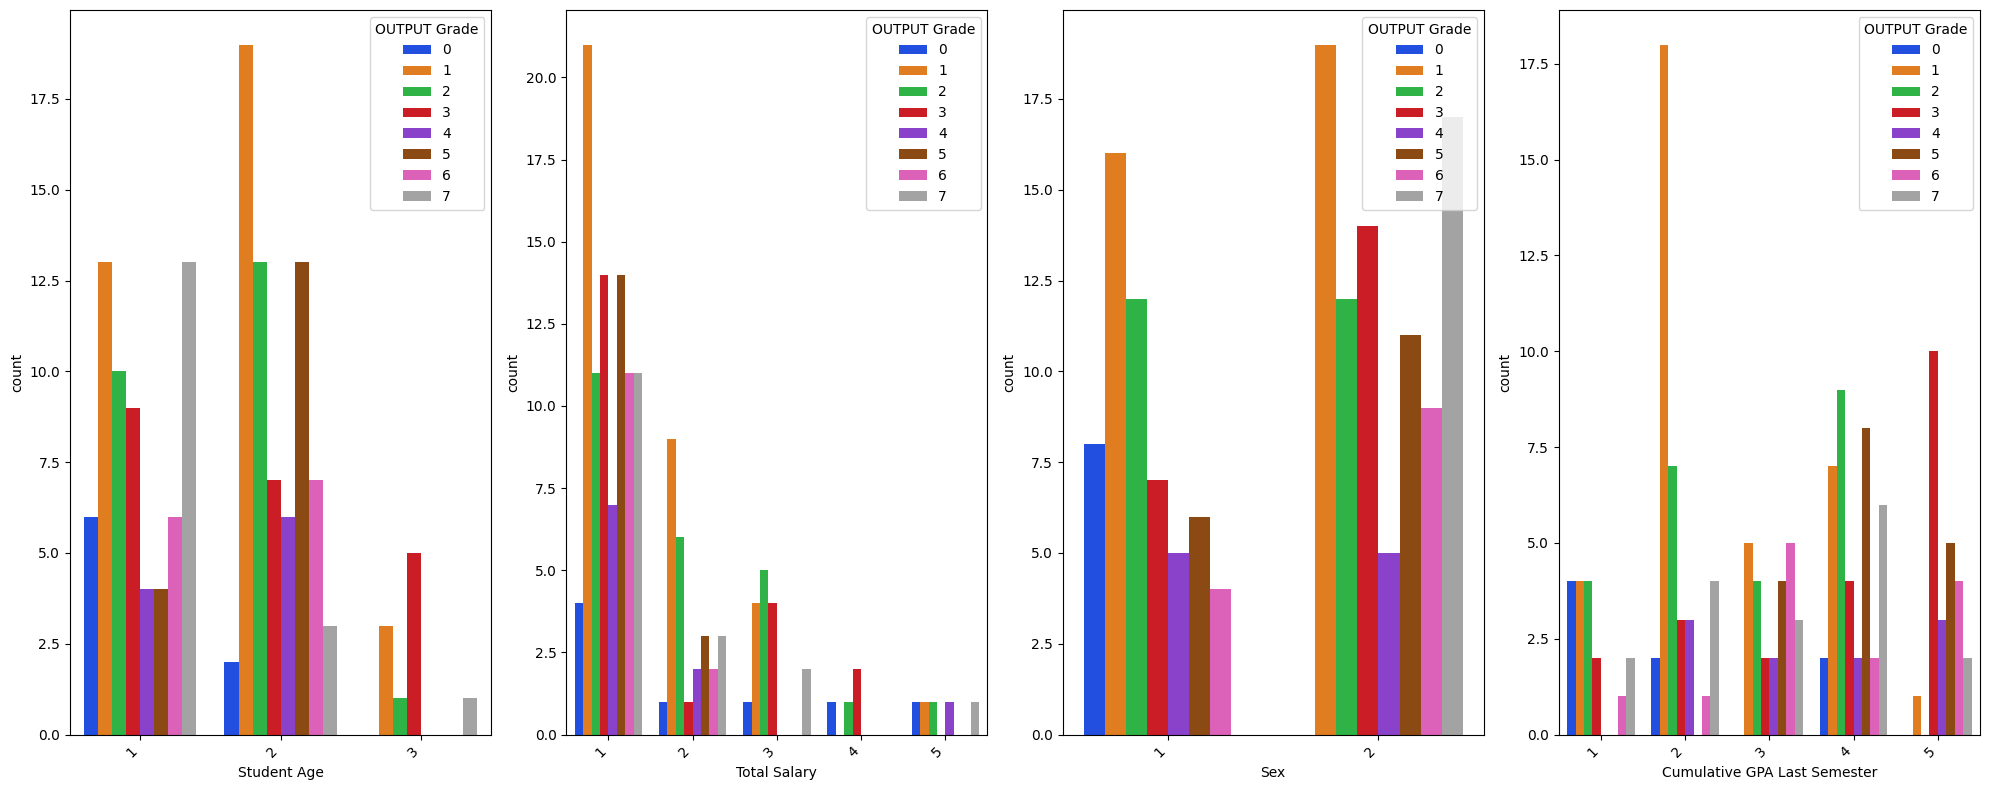

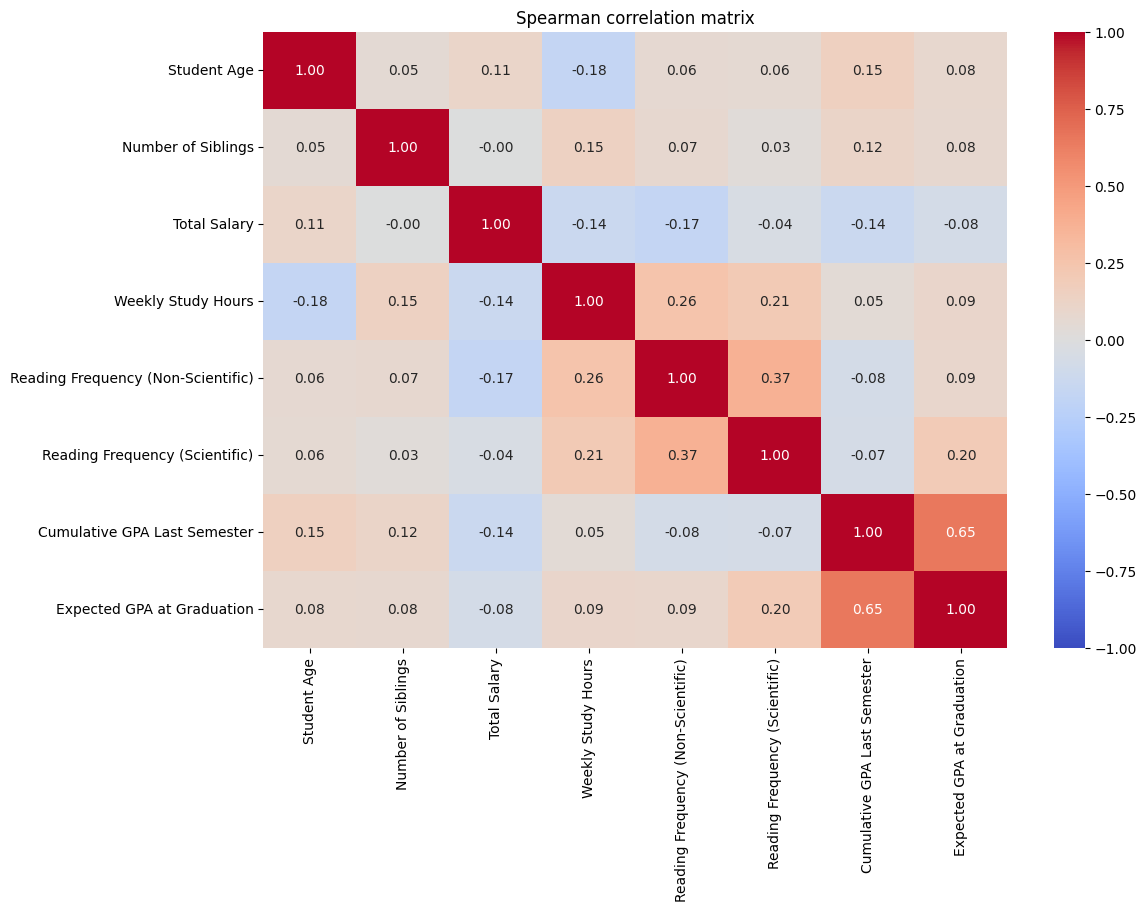

Division de datos completada

Conjunto de entrenamiento: (101, 31) (101,)
Conjunto de validacion: (22, 31) (22,)
Conjunto de prueba: (22, 31) (22,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


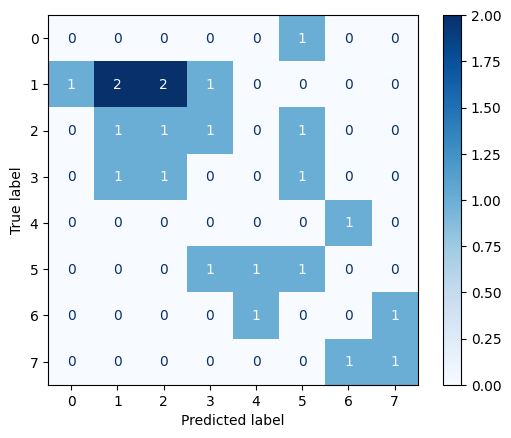

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.33      0.40         6
           2       0.25      0.25      0.25         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.25      0.33      0.29         3
           6       0.00      0.00      0.00         2
           7       0.50      0.50      0.50         2

    accuracy                           0.23        22
   macro avg       0.19      0.18      0.18        22
weighted avg       0.26      0.23      0.24        22

Accuracy con validacion cruzada: 0.1086


In [15]:
model = StudentPerformanceModel(dataset_id=856)
model.load_data()

# EDA
DataExplorer.explore_data(model.data) #def explore_data(data):
DataExplorer.plot_categorical_distributions(model.data, ['Student Age', 'Total Salary','Sex', 'Cumulative GPA Last Semester'],'OUTPUT Grade' )#def plot_categorical_distributions(data, columns, target):
DataExplorer.plot_correlation_matrix(model.data[['Student Age', 'Number of Siblings', 'Total Salary', 'Weekly Study Hours', 'Reading Frequency (Non-Scientific)',
                                   'Reading Frequency (Scientific)', 'Cumulative GPA Last Semester', 'Expected GPA at Graduation']],
                                     method='spearman')#def plot_correlation_matrix(data, method='spearman'):


# Modelo y preprocesamiento

model.load_data().preprocess_data().encode_target().build_pipeline().apply_pipeline().train_model_dtree().evaluate_model().cross_validate_model()

Accuraccy: Verdaderos positivos/VP predichos, para la clase 1, tenemos un 33%

Recall: Verdaderos positivos/positivos reales, 0.17

Support: categorias reales en cada clase

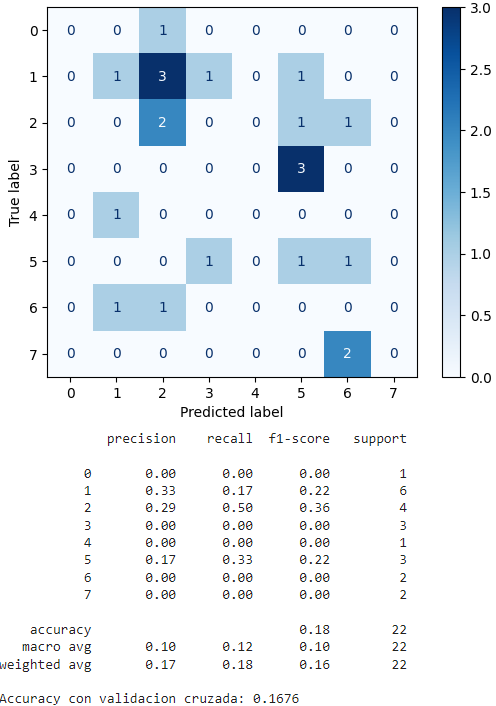

**Student ID**

**1- Student Age**

(1: 18-21,

2: 22-25,

3: above 26)

**2- Sex**

(1: female,

2: male)

**3- Graduated high-school type:**

(1: private,

2: state,

3: other)

**4- Scholarship type:**

(1: None,

2: 25%,

3: 50%,

4: 75%,

5: Full)

**5- Additional work:**

(1: Yes,

2: No)

**6- Regular artistic or sports activity:**

(1: Yes,

2: No)

**7- Do you have a partner:**

(1: Yes,

2: No)

**8- Total salary if available**

(1: USD 135-200,

2: USD 201-270,

3: USD 271-340,

4: USD 341-410,

5: above 410)

**9- Transportation to the university:**

(1: Bus,

2: Private car/taxi,

3: bicycle,

4: Other)

**10- Accommodation type in Cyprus:**

(1: rental,

2: dormitory,

3: with family,

4: Other)

**11- Mothers education:**

(1: primary school,

2: secondary school,

3: high school,

4: university,

5: MSc.,

6: Ph.D.)

**12- Fathers education:**

(1: primary school,

2: secondary school,

3: high school,

4: university,

5: MSc.,

6: Ph.D.)

**13- Number of sisters/brothers (if available):**

(1: 1,

2:, 2,

3: 3,

4: 4,

5: 5 or above)

**14- Parental status:**

(1: married,

2: divorced,

3: died - one of them or both)

**15- Mothers occupation:**

(1: retired,

2: housewife,

3: government officer,

4: private sector employee,

5: self-employment,

6: other)

**16- Fathers occupation:**

(1: retired,

2: government officer,

3: private sector employee,

4: self-employment,

5: other)

**17- Weekly study hours:**

(1: None,

2: <5 hours,

3: 6-10 hours,

4: 11-20 hours,

5: more than 20 hours)

**18- Reading frequency (non-scientific books/journals):**

(1: None,

2: Sometimes,

3: Often)

**19- Reading frequency (scientific books/journals):**

(1: None,

2: Sometimes,

3: Often)

**20- Attendance to the seminars/conferences related to the department:**

(1: Yes,

2: No)

**21- Impact of your projects/activities on your success:**

(1: positive,

2: negative,

3: neutral)

**22- Attendance to classes**

(1: always,

2: sometimes,

3: never)

**23- Preparation to midterm exams 1:**

(1: alone,

2: with friends,

3: not applicable)

**24- Preparation to midterm exams 2:**

(1: closest date to the exam,

2: regularly during the semester,

3: never)

**25- Taking notes in classes:**

(1: never,

2: sometimes,

3: always)

**26- Listening in classes:**

(1: never,

2: sometimes,

3: always)

**27- Discussion improves my interest and success in the course:**

(1: never,

2: sometimes,

3: always)

**28- Flip-classroom:**

(1: not useful,

2: useful,

3: not applicable)

**29- Cumulative grade point average in the last semester (/4.00):**

(1: <2.00,

2: 2.00-2.49,

3: 2.50-2.99,

4: 3.00-3.49,

5: above 3.49)

**30- Expected Cumulative grade point average in the graduation (/4.00):**

(1: <2.00,

2: 2.00-2.49,

3: 2.50-2.99,

4: 3.00-3.49,

5: above 3.49)

**31- Course ID**

**32- OUTPUT Grade**

(0: Fail,

1: DD,

2: DC,

3: CC,

4: CB,

5: BB,

6: BA,

7: AA)

**Variables categoricas nominales (no tienen un orden):**

2- Sex

3- Graduated high-school type

4- Scholarship type

9- Transportation to the university

10- Accommodation type in Cyprus

14- Parental status

15- Mothers occupation

16- Fathers occupation

21- Impact of your projects/activities on your success

22- Attendance to classes

23- Preparation to midterm exams 1

24- Preparation to midterm exams 2

27- Discussion improves my interest and success

28- Flip-classroom

**Variables categricas ordinales:**

1- Student Age

4- Scholarship type

13- Number of sisters/brothers

8- Total salary if available

11- Mothers education

12- Fathers education

17- Weekly study hours

18- Reading frequency (non-scientific books/journals)

19- Reading frequency (scientific books/journals)

25- Taking notes in classes

26- Listening in classes

29- Cumulative grade point average in the last semester

30- Expected Cumulative grade point average in the graduation

**Variables binarias:**

2- Sex

5- Additional work

6- Regular artistic or sports activity

7- Do you have a partner

20- Attendance to the seminars/conferences


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
higher_education_students_performance_evaluation = fetch_ucirepo(id=856)

# data (as pandas dataframes)
X = higher_education_students_performance_evaluation.data.features
y = higher_education_students_performance_evaluation.data.targets


# Concatenamos ambos datasets (feature y target)
df = pd.concat([X, y], axis = 1)
column_names = ['Student Age', 'Sex', 'Graduated High-school Type',
                'Scholarship Type', 'Additional Work', 'Regular Artistic/Sports Activity',
                'Do you have a Partner', 'Total Salary', 'Transportation',
                'Accommodation in Cyprus', 'Mothers Education', 'Fathers Education',
                'Number of Siblings', 'Parental Status', 'Mothers Occupation',
                'Fathers Occupation', 'Weekly Study Hours', 'Reading Frequency (Non-Scientific)',
                'Reading Frequency (Scientific)', 'Attendance to Seminars', 'Impact on Success',
                'Attendance to Classes', 'Preparation to Midterm 1', 'Preparation to Midterm 2',
                'Taking Notes in Classes', 'Listening in Classes',
                'Discussion Improves Success', 'Flip-Classroom',
                'Cumulative GPA Last Semester', 'Expected GPA at Graduation', 'COURSE ID', 'OUTPUT Grade']

df.columns = column_names

df.head(5)

,Student Age,Sex,Graduated High-school Type,Scholarship Type,Additional Work,Regular Artistic/Sports Activity,Do you have a Partner,Total Salary,Transportation,Accommodation in Cyprus,...,Preparation to Midterm 1,Preparation to Midterm 2,Taking Notes in Classes,Listening in Classes,Discussion Improves Success,Flip-Classroom,Cumulative GPA Last Semester,Expected GPA at Graduation,COURSE ID,OUTPUT Grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


# Analisis descriptivo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Student Age                         145 non-null    int64
 1   Sex                                 145 non-null    int64
 2   Graduated High-school Type          145 non-null    int64
 3   Scholarship Type                    145 non-null    int64
 4   Additional Work                     145 non-null    int64
 5   Regular Artistic/Sports Activity    145 non-null    int64
 6   Do you have a Partner               145 non-null    int64
 7   Total Salary                        145 non-null    int64
 8   Transportation                      145 non-null    int64
 9   Accommodation in Cyprus             145 non-null    int64
 10  Mothers Education                   145 non-null    int64
 11  Fathers Education                   145 non-null    int64
 12  Number o

In [ ]:
import plotly.express as px

fig = px.histogram(df, x="Sex", color="OUTPUT Grade", barmode="group", template="plotly_white", title="Distribution of Sex by OUTPUT Grade")
fig.update_traces(marker_line_width=1, opacity=0.7)

fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)
fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Aseguramos que las columnas categóricas sean tratadas como tales
df['Sex'] = df['Sex'].astype('category')
df['Graduated High-school Type'] = df['Graduated High-school Type'].astype('category')
df['Reading Frequency (Scientific)'] = df['Reading Frequency (Scientific)'].astype('category')

# Crear figura con subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Sex", "Graduated High-school Type", "Reading Frequency", "Cumulative GPA"))

# Agregar gráficas de barras con barmode="group" para que cada valor de OUTPUT Grade se agrupe en cada categoría de X
fig.add_trace(go.Bar(x=df['Sex'], y=df['Sex'].value_counts(), name='Sex', marker=dict(color='blue')), row=1, col=1)
fig.add_trace(px.histogram(df, x="Sex", color="OUTPUT Grade", barmode="group").data[0], row=1, col=1)

fig.add_trace(go.Bar(x=df['Graduated High-school Type'], y=df['Graduated High-school Type'].value_counts(), name='Graduated High-school Type', marker=dict(color='blue')), row=1, col=2)
fig.add_trace(px.histogram(df, x="Graduated High-school Type", color="OUTPUT Grade", barmode="group").data[0], row=1, col=2)

fig.add_trace(go.Bar(x=df['Reading Frequency (Scientific)'], y=df['Reading Frequency (Scientific)'].value_counts(), name='Reading Frequency', marker=dict(color='blue')), row=2, col=1)
fig.add_trace(px.histogram(df, x="Reading Frequency (Scientific)", color="OUTPUT Grade", barmode="group").data[0], row=2, col=1)

fig.add_trace(go.Bar(x=df['Cumulative GPA Last Semester'], y=df['Cumulative GPA Last Semester'].value_counts(), name='Cumulative GPA', marker=dict(color='blue')), row=2, col=2)
fig.add_trace(px.histogram(df, x="Cumulative GPA Last Semester", color="OUTPUT Grade", barmode="group").data[0], row=2, col=2)

# Ajustar el layout
fig.update_layout(
    title_text="Multiple Variables Comparison",
    showlegend=True,  # Para mostrar la leyenda con los valores de OUTPUT Grade
    barmode='group',  # Agrupación de las barras
)

# Mostrar la figura
fig.show()